# Overview 

This notebook describes how to construct GRN models in CellOracle. 
Please read our paper first to know about the CellOracle's GRN modeling algorithm.

Last update: 4/13/2022, Kenji Kamimoto

### Notebook file
Notebook file is available on CellOracle's GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb


### Data
CellOracle uses two types of input data during the GRN model construction.

- **Input data 1: scRNA-seq data**. Please look at the previous section to learn about the scRNA-seq data preprocessing. https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html


- **Input data 2: Base-GRN**. The base GRN represents the TF-target gene connections. The data structure is a binary 2D matrix or linklist. Please look at our paper to know the concept of base GRN.

 - CellOracle typically uses a base GRN constructed from scATAC-seq data. If you would like to create a custom base GRN using your scATAC-seq data, please refer to the following notebook. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html
 - If you do not have any sample-specific scATAC-seq data that correspond to the same/similar cell type of the scRNA-seq data, please use pre-built base GRN.  
 - We provide multiple options for pre-built base GRN. For analyses in mice, we recommend using a base GRN built from the mouse sciATAC-seq Atlas dataset. It includes various tissues and various cell types. Another option is using base GRN constructed from promoter database. We provide promoter base GRNs for ten species.

### What you can do
After constructing the CellOracle GRN models, you can do two analyses.

1. **in silico TF perturbation analysis**. CellOracle uses the GRN models to simulate cell identity shifts in response to TF perturbation. For this analysis, you must first construct your GRN models in this notebook.

2. **Network analysis**. You can analyze the GRN models using graph theory. We provide several functions. 
 - CellOracle construct cluster-wise GRN models. You can compare the GRN model structure between clusters, which allows you to investigate the cell type-specific GRN configurations and explore structual changes as GRNs are rewired along the cell differentiation trajectory.
 - You can also export the network models and analyze the GRN models using external packages or softwares. 
 
### Custom data classes / objects

In this notebook, CellOracle uses two custom classes, `Oracle` and `Links`.

- `Oracle` is the main class in the CellOracle package. It is responsible for almost all the GRN model construction and TF perturbation simulation. `Oracle` does the following calculations sequentially.
 1. Import scRNA-sequence data. Please refer to the data preparation notebooks to learn about data preparation procedures.
 2. Import base GRN data.
 3. scRNA-seq data processing. 
 4. GRN model construction.
 5. in silico petrurbation. We will describe how to do this in the following notebook.

- `Links` is a class to store GRN data. It also conteins many functions for network analysis and visualization.


# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [27]:
import celloracle as co
co.__version__

'0.10.1'

In [28]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [18]:
co.test_R_libraries_installation()

## 0.2. Make a folder to save graph

In [19]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)

Please refer to the previous notebook to learn about scRNA-seq data processing.
https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html

The scRNA-seq data must be in the anndata format.

> **This CellOracle tutorial notebook assumes the user has basic knowledge and experience with scRNA-seq analysis using Scanpy and Anndata.** This notebook is not intended to be an introduction to Scanpy or Anndata. 
> If you are not familiar with them, please learn them using the documentation and tutorials for Scanpy (https://scanpy.readthedocs.io/en/stable/) and annata (https://anndata.readthedocs.io/en/stable/).



In [7]:
def preprocess_pipeline(adata, exclude_high_ribo = True, exclude_high_mito =True, 
                                exclude_doublets = True, exclude_undected_gene = True ,cq_threhold = 95): 
    # run your pipeline
    
    ####### Part 2 ########
    adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
    
    if exclude_high_ribo == False:
        # Filter out doublets
        thresh = np.percentile(adata.obs['total_counts'],cq_threhold)
        adata = adata[adata.obs['total_counts'] < thresh, :]
        # Filter out low quality cells 
        adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        adata = adata[adata.obs['total_counts'] > 10000, :]
        # skip the high ribo percent filtering step
        # filter out undetected genes that are expressed in less than 5 cells 
        sc.pp.filter_genes(adata, min_cells=5)
    elif exclude_high_mito == False:
        thresh = np.percentile(adata.obs['total_counts'],cq_threhold)
        adata = adata[adata.obs['total_counts'] < thresh, :]
        # adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
        adata = adata[adata.obs['total_counts'] > 10000, :]
        sc.pp.filter_genes(adata, min_cells=5)
    elif exclude_doublets == False:
        # thresh = np.percentile(adata.obs['total_counts'],cq_threhold)
        # adata = adata[adata.obs['total_counts'] < thresh, :]
        adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
        adata = adata[adata.obs['total_counts'] > 10000, :]
        sc.pp.filter_genes(adata, min_cells=5)
    elif exclude_undected_gene == False:
        thresh = np.percentile(adata.obs['total_counts'],cq_threhold)
        adata = adata[adata.obs['total_counts'] < thresh, :]
        adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
        adata = adata[adata.obs['total_counts'] > 10000, :]
        # sc.pp.filter_genes(adata, min_cells=5)
    else:
        thresh = np.percentile(adata.obs['total_counts'],cq_threhold)
        adata = adata[adata.obs['total_counts'] < thresh, :]
        adata = adata[adata.obs['pct_counts_mt'] < 5, :]
        adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
        adata = adata[adata.obs['total_counts'] > 10000, :]
        sc.pp.filter_genes(adata, min_cells=5)

    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')
    sc.pl.highest_expr_genes(adata, n_top=10)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    ####### Part 3 ########
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.25)
    # scaling the gene expression
    sc.pp.scale(adata, max_value=10)
    adata.raw = adata
    sc.set_figure_params(figsize="10, 4")
    # computate dimensional reduction. PCA 
    sc.tl.pca(adata, n_comps=100,use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,100, )
    n_pcs = 20
    n_neighbors = 15
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.leiden(adata, .25)

    return adata

In [2]:
adata = sc.read_h5ad("Kannan_perinatal_reference.h5ad")
adata

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

/Users/zhonglelin/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


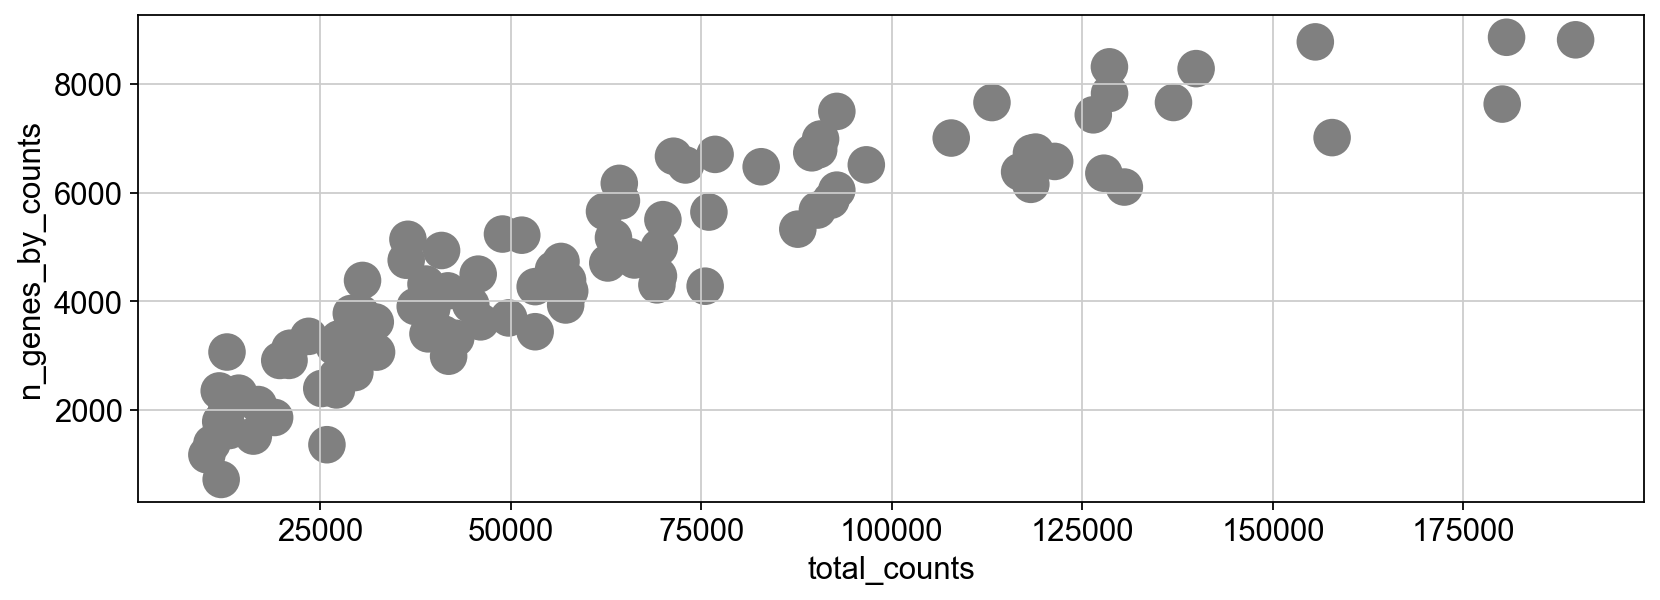

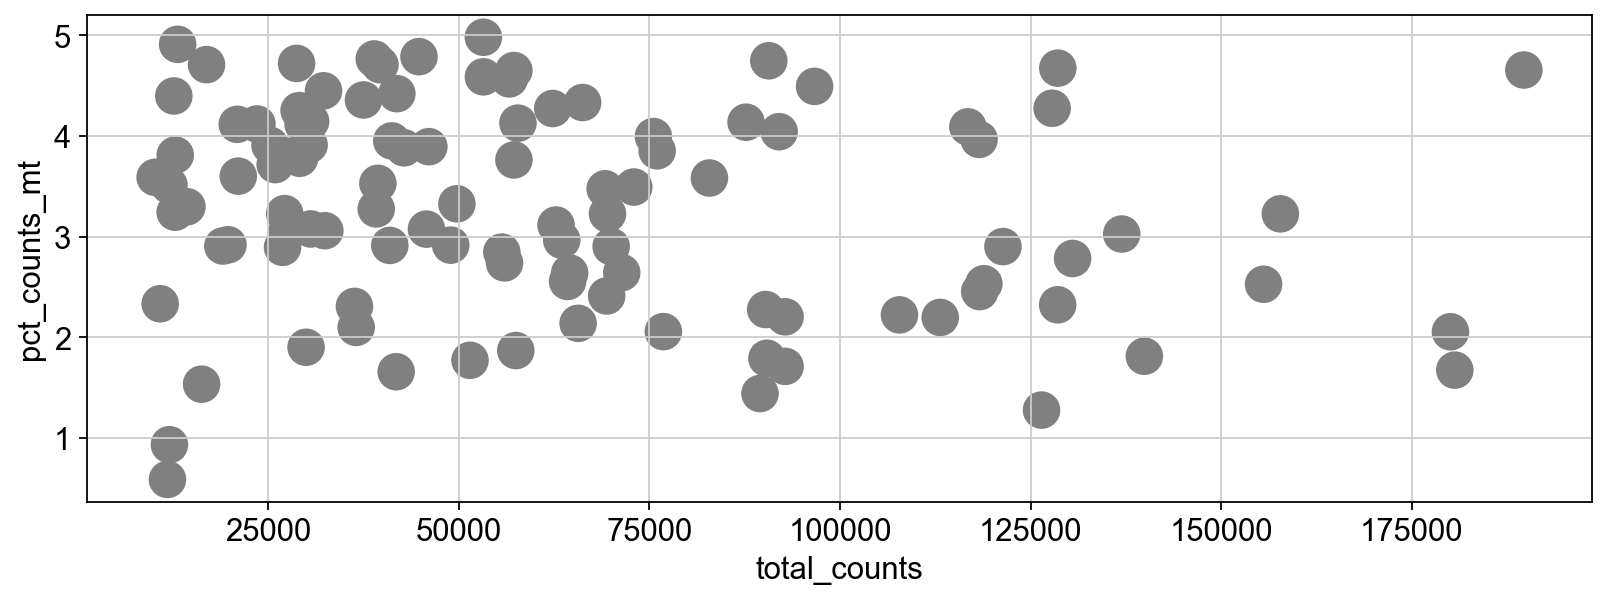

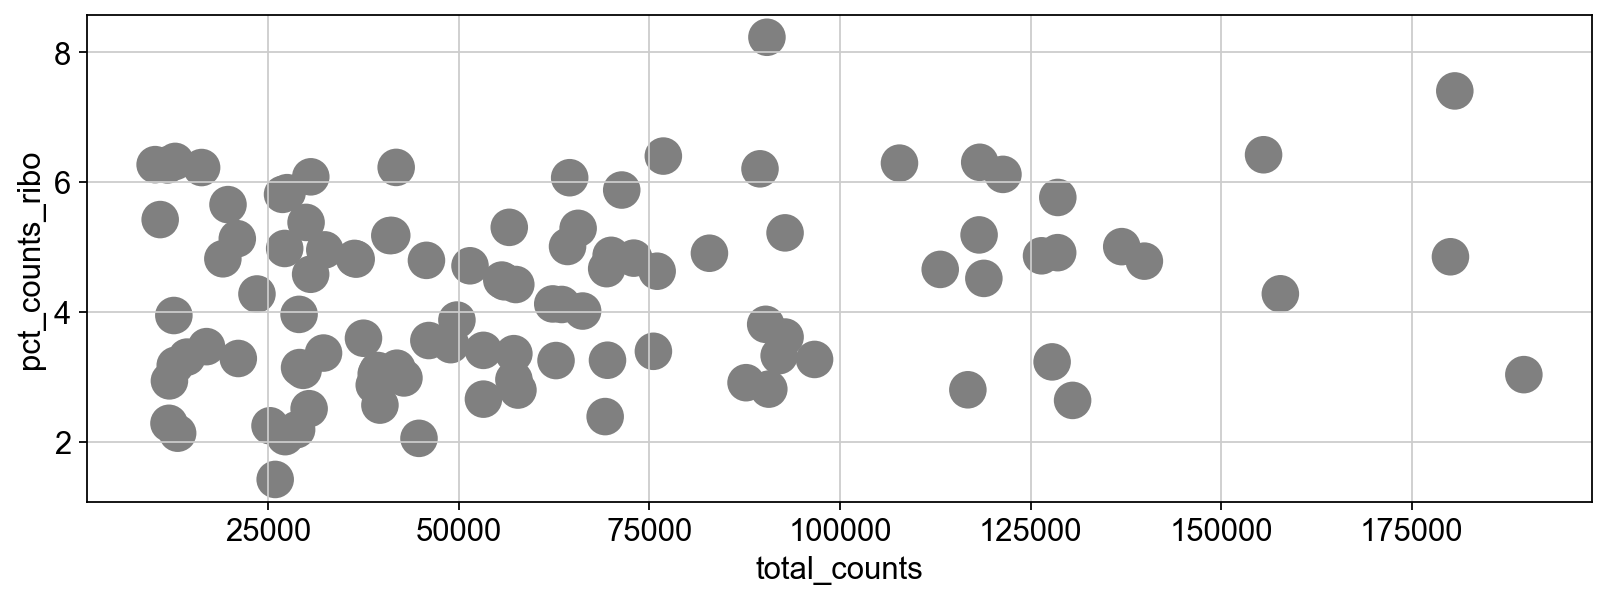

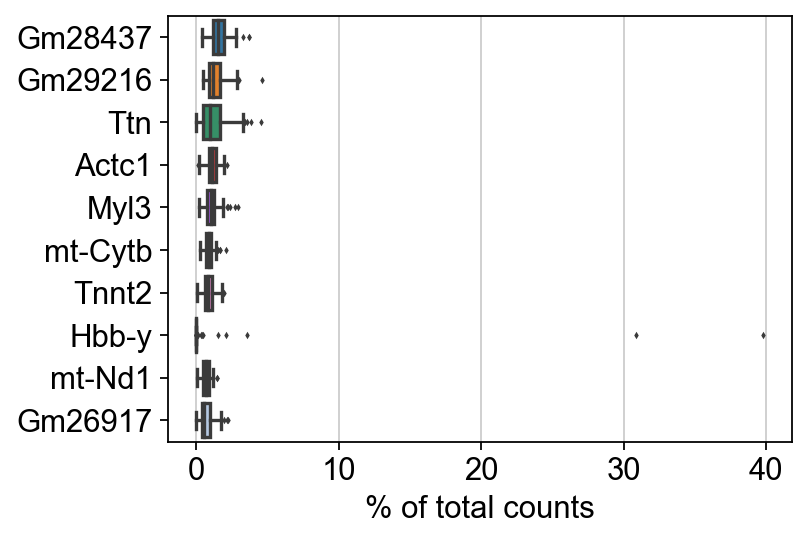

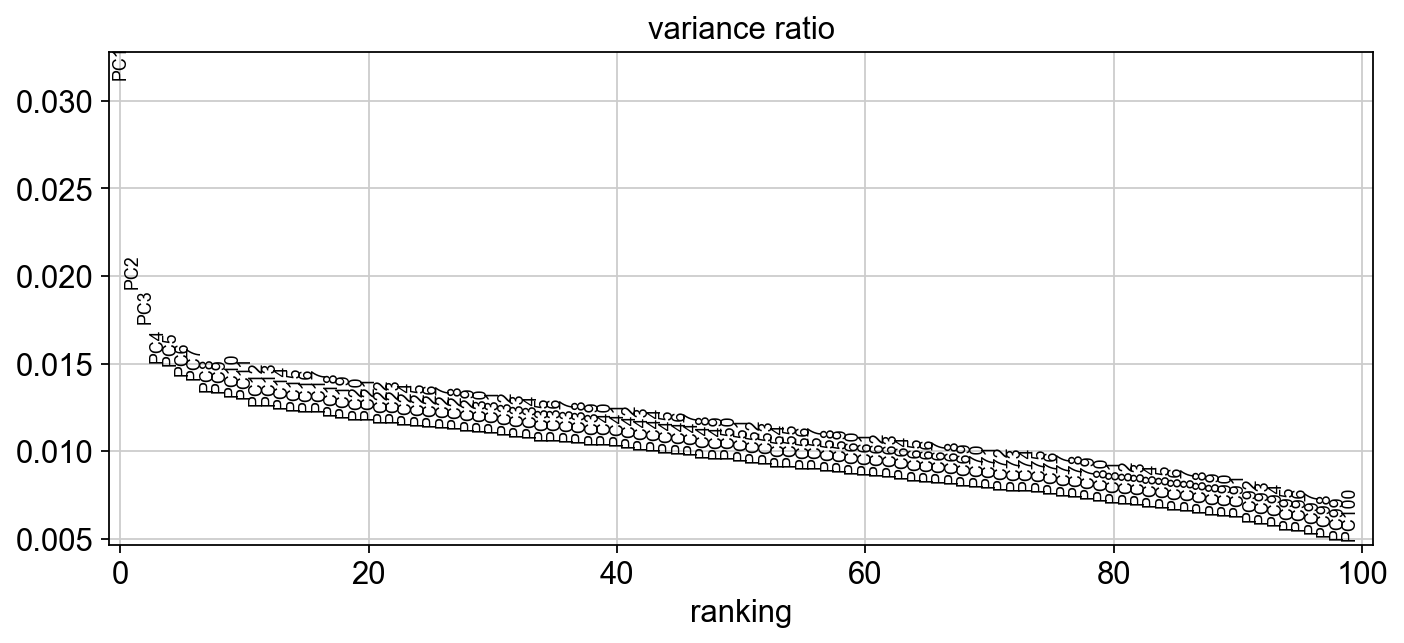

AnnData object with n_obs × n_vars = 105 × 13943
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
preprocessed_adata = preprocess_pipeline(adata, exclude_high_ribo = True, exclude_high_mito =True, 
                                exclude_doublets = True, exclude_undected_gene = True ,cq_threhold = 95)
preprocessed_adata

In [3]:
import h5py
print(h5py.__version__)

3.6.0


In [24]:
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Bio                         1.79
PIL                         8.2.0
anyio                       NA
appdirs                     1.4.4
appnope                     0.1.2
attr                        21.4.0
babel                       2.9.0
backcall                    0.2.0
biothings_client            0.2.6
boltons                     NA
bottleneck                  1.3.2
brotli                      NA
bucketcache                 0.12.1
cairo          

## 1.2. (Optional step) Downsampling

If your scRNA-seq data includes more than 20-30K cells, we recommend downsampling your data. If you do not, please note the perturbation simulations may require large amounts of memory in the next notebook. 

Also, please pay attention to the number of genes. If you are following the instruction from the previous tutorial notebook, the scRNA-seq data should include only top 2~3K variable genes. If you have more than 3K genes, it may cause issues downstream.

In [6]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :2671
Gene number is :1999


In [7]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000 

if adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [8]:
print(f"Cell number is :{adata.shape[0]}")

Cell number is :2671


## 1.2. Load base-GRN data. 
To infer cluster-specific GRNs, CellOracle requires a base GRN. 
- There are several ways to make a base GRN. We can typically generate base GRN from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial to learn more about this process. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html


- If you do not have your scATAC-seq data, you can use one of the built-in base GRNs options below. 

- Base GRNs made from mouse sci-ATAC-seq atlas : The built-in base GRN was made from various tissue/cell-types found in the atlas (http://atlas.gs.washington.edu/mouse-atac/). We recommend using this for mouse scRNA-seq data. Please load this data as follows.

 `base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()`


- Promoter base GRN: We also provide base GRN made from promoter DNA-sequences for ten species. You can load this data as follows.

 - e.g. for Human: `base_GRN = co.data.load_human_promoter_base_GRN()`



In [9]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

# Check data
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Initiate Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [10]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

For the CellOracle analysis, your anndata should include (1) gene expression counts, (2) clustering information, and (3) trajectory (dimensional reduction embedding) data. Please refer to a previous notebook for more information on anndata preprocessing.


When you load the scRNA-seq data, please enter **the name of the clustering data** and **the name of the dimensionality reduction.**
 - The clustering data should be to be stored in the `obs` the attribute of anndata. 
  > You can check it using the following command.
  >
  > `adata.obs.columns`
  
 - Dimensional reduction data is stored in the `obsm` the attribute of anndata. 
  > You can check it with the following command.
  > 
  > `adata.obsm.keys()`
  


In [11]:
# Show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))

metadata columns : ['paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'dpt_pseudotime']
dimensional reduction:  ['X_diffmap', 'X_draw_graph_fa', 'X_pca']


In [12]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain_annot",
                                   embedding_name="X_draw_graph_fa")

## 2.2. Load base-GRN data into oracle object

In [13]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

## 2.3. (Optional) Add TF-target gene pair manually

We can add additional TF-target gene pairs manually.

For example, if there is a study or database that includes specific TF-target pairs, you can include this information using a python dictionary. 


### 2.3.1. Make dictionary
Here, we will introduce how to manually add TF-target gene pair data. 

As an example, we will use TF binding data from supplemental table 4 in the Paul et al., (2015) paper. (http://doi.org/10.1016/j.cell.2015.11.013).

You can download this file by running the command below. Or download it manually here.
https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/TF_data_in_Paul15.csv


In order to import the TF data into the Oracle object, we need to convert it into a python dictionary. The dictionary keys will be the target gene, and dictionary values will be a list of regulatory candidate TFs.

In [3]:
# Download file. 
!wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/TF_data_in_Paul15.csv
    
# If you are using macOS, please try the following command.
#!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/TF_data_in_Paul15.csv  

--2021-06-09 15:13:52--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/notebooks/04_Network_analysis/TF_data_in_Paul15.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1768 (1.7K) [text/plain]
Saving to: ‘TF_data_in_Paul15.csv’

TF_data_in_Paul15.c 100%[===================>]   1.73K  --.-KB/s    in 0s      

2021-06-09 15:13:52 (11.8 MB/s) - ‘TF_data_in_Paul15.csv’ saved [1768/1768]



In [14]:
# Load the TF and target gene information from Paul et al. (2015).
Paul_15_data = pd.read_csv("TF_data_in_Paul15.csv")
Paul_15_data


,TF,Target_genes
0,Cebpa,"Abcb1b, Acot1, C3, Cnpy3, Dhrs7, Dtx4, Edem2, ..."
1,Irf8,"Abcd1, Aif1, BC017643, Cbl, Ccdc109b, Ccl6, d6..."
2,Irf8,"1100001G20Rik, 4732418C07Rik, 9230105E10Rik, A..."
3,Klf1,"2010011I20Rik, 5730469M10Rik, Acsl6, Add2, Ank..."
4,Spi1,"0910001L09Rik, 2310014H01Rik, 4632428N05Rik, A..."


In [15]:
# Make dictionary: dictionary key is TF and dictionary value is list of target genes.
TF_to_TG_dictionary = {}

for TF, TGs in zip(Paul_15_data.TF, Paul_15_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

  0%|          | 0/178 [00:00<?, ?it/s]

### 2.3.2. Add TF information dictionary into the oracle object

In [16]:
# Add TF information 
oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

# 3. KNN imputation
CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

## 3.1. PCA

45


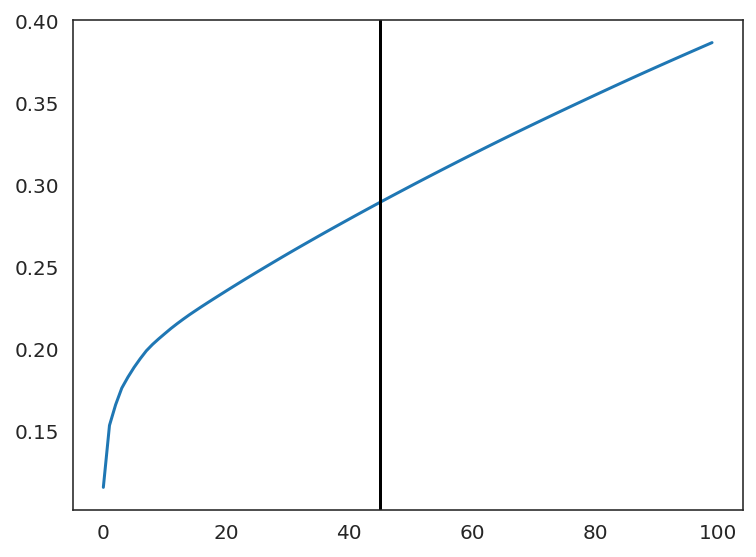

In [17]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [18]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :2671


In [19]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :66


In [20]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.

You can save your `Oracle` object using `Oracle.to_hdf5(FILE_NAME.celloracle.oracle)`. 

Pleasae use `co.load_hdf5(FILE_NAME.celloracle.oracle)` to load the saved file.


In [21]:
# Save oracle object.
oracle.to_hdf5("Paul_15_data.celloracle.oracle")

In [22]:
# Load file.
oracle = co.load_hdf5("Paul_15_data.celloracle.oracle")

# 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

- You can calculate GRNs with the `get_links` function, and it will return the results as a `Links` object.
The `Links` object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the `Links` object.

- A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.



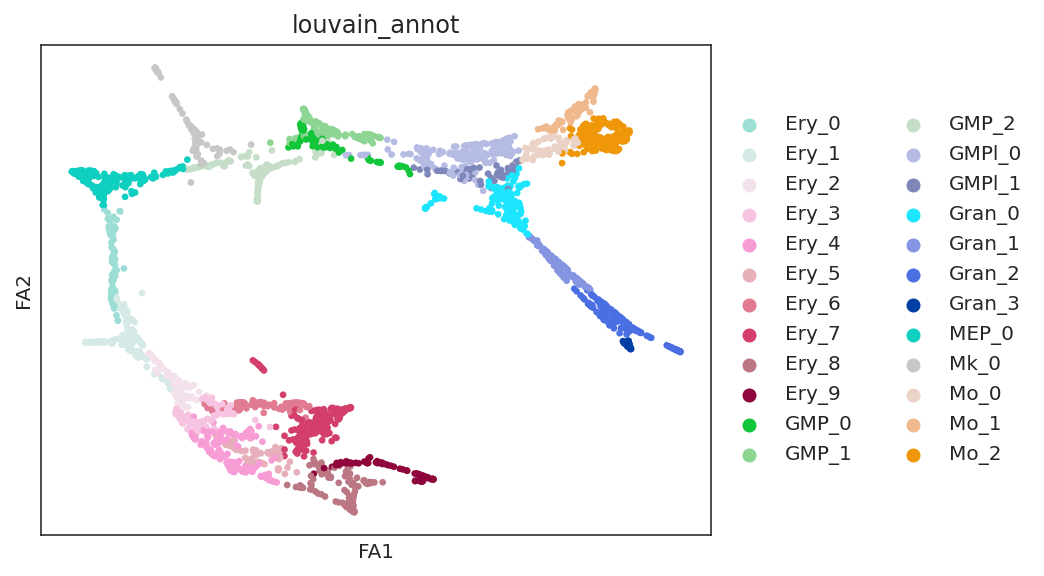

In [23]:
# check data
sc.pl.draw_graph(oracle.adata, color="louvain_annot")

## 5.1. Get GRNs

In [24]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=10)

  0%|          | 0/24 [00:00<?, ?it/s]

inferring GRN for Ery_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_1...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_2...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_3...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_4...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_5...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_6...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_7...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_8...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Ery_9...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for GMP_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for GMP_1...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for GMP_2...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for GMPl_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for GMPl_1...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Gran_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Gran_1...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Gran_2...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Gran_3...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for MEP_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Mk_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Mo_0...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Mo_1...


  0%|          | 0/1850 [00:00<?, ?it/s]

inferring GRN for Mo_2...


  0%|          | 0/1850 [00:00<?, ?it/s]

CPU times: user 15min 53s, sys: 28.2 s, total: 16min 21s
Wall time: 16min 34s


## 5.2. (Optional) Export GRNs

Although CellOracle has many functions for network analysis, you can export and analyze GRNs using another software if you chose.
The raw GRN data is stored as a dictionary of dataframe in the `links_dict` attribute.

For example, you can get the GRN for the "Ery_0" cluster with the following commands.

In [25]:
links.links_dict.keys()

dict_keys(['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1', 'Mo_2'])

In [26]:
links.links_dict["Ery_0"]

,source,target,coef_mean,coef_abs,p,-logp
0,Klf2,0610007L01Rik,0.000000,0.000000,NaN,-0.000000
1,Nfkb1,0610007L01Rik,0.003939,0.003939,1.073624e-02,1.969148
2,Ets1,0610007L01Rik,0.012473,0.012473,1.324632e-08,7.877905
3,Chd2,0610007L01Rik,-0.010744,0.010744,4.196722e-07,6.377090
4,Mycn,0610007L01Rik,-0.002120,0.002120,2.182405e-01,0.661065
...,...,...,...,...,...,...
74932,Stat5a,Zyx,-0.018057,0.018057,2.196474e-06,5.658274
74933,Elf1,Zyx,0.003506,0.003506,7.699489e-02,1.113538
74934,Prdm5,Zyx,-0.003168,0.003168,1.803649e-01,0.743848
74935,Cxxc1,Zyx,-0.008056,0.008056,4.062705e-04,3.391185


You can export the file as follows.

In [27]:
# Set cluster name
cluster = "Ery_0"

# Save as csv
#links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")

## 5.3. (Optional) Change order

The links object stores color information in the `palette` attribute.
This information is used when visualizing the clusters.

The sample will be visualized in that order. 
Here we can change both the cluster colors and order.

In [28]:
# Show the contents of pallete
links.palette

,palette
Ery_0,#9CDED6
Ery_1,#D5EAE7
Ery_2,#F3E1EB
Ery_3,#F6C4E1
Ery_4,#F79CD4
Ery_5,#E6AFB9
Ery_6,#E07B91
Ery_7,#D33F6A
Ery_8,#BB7784
Ery_9,#8E063B


In [29]:
# Change the order of pallete
order = ['MEP_0', 'Mk_0', 'Ery_0', 
         'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9',
         'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1',
         'Mo_0', 'Mo_1', 'Mo_2', 
         'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3']
links.palette = links.palette.loc[order]
links.palette

,palette
MEP_0,#0FCFC0
Mk_0,#C7C7C7
Ery_0,#9CDED6
Ery_1,#D5EAE7
Ery_2,#F3E1EB
Ery_3,#F6C4E1
Ery_4,#F79CD4
Ery_5,#E6AFB9
Ery_6,#E07B91
Ery_7,#D33F6A


In [30]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

# 6. Network preprocessing

## 6.1. Filter network edges 

Using the base GRN, CellOracle constructs the GRN models as a lits of directed edges between a TF and its target genes.
We need to remove the weak edges or insignificant edges before doing network structure analysis.

We filter the network edges as follows.

1. Remove uncertain network edges based on the p-value.
 
2. Remove weak network edge. In this tutorial, we keep the top 2000 edges ranked by edge strength.


The raw network data is stored in the `links_dict` attribute, while the filtered network data is stored in the `filtered_links` attribute. 


In [31]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.

>Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [32]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Ery_0


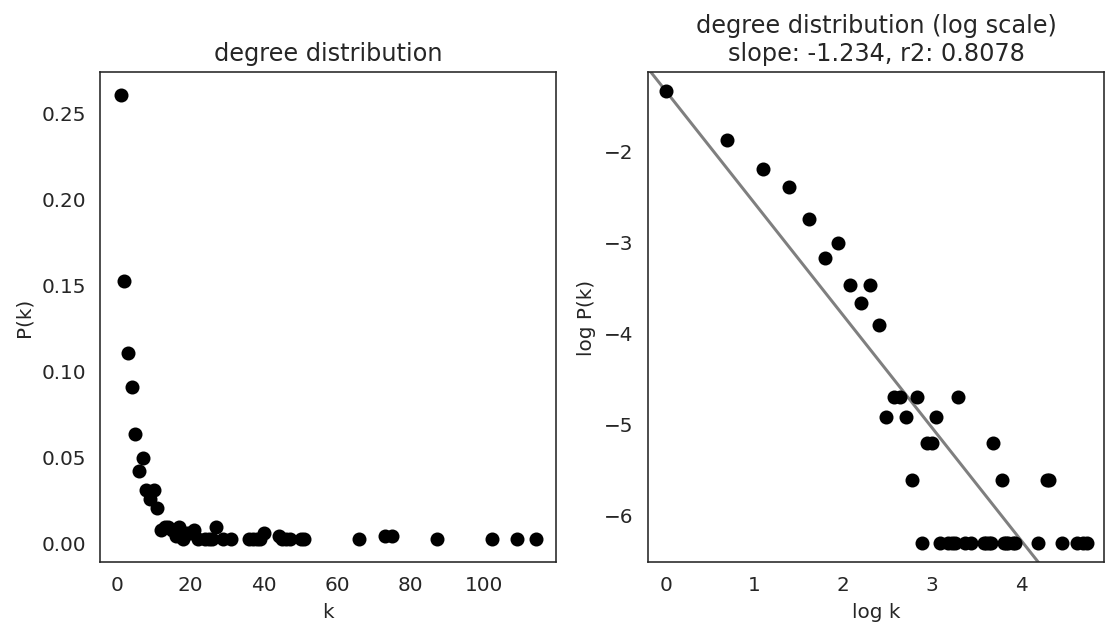

Ery_1


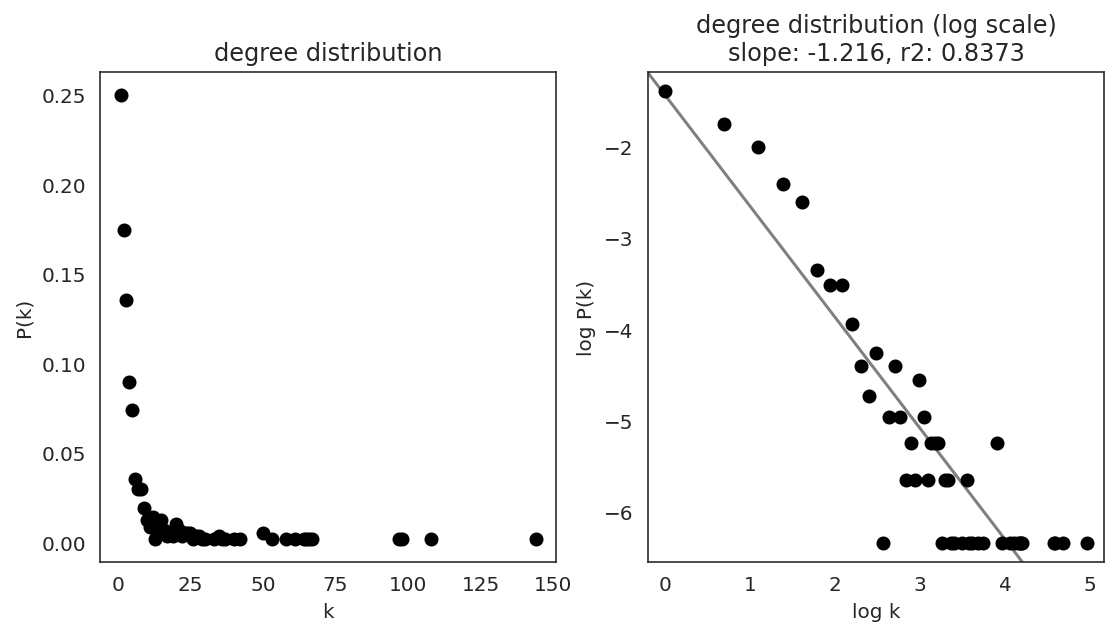

Ery_2


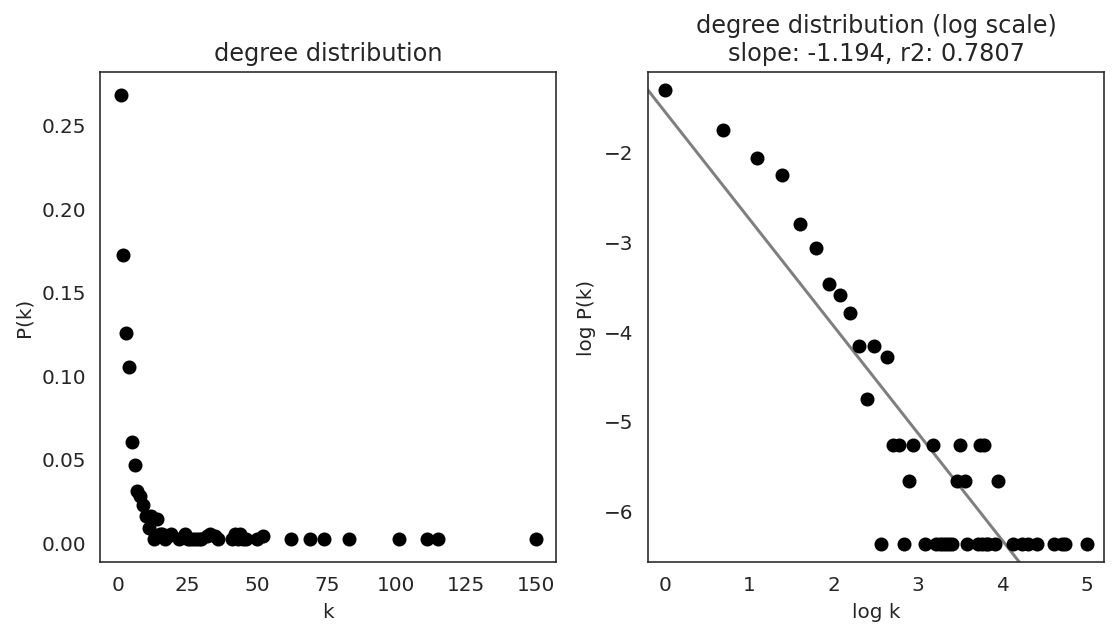

Ery_3


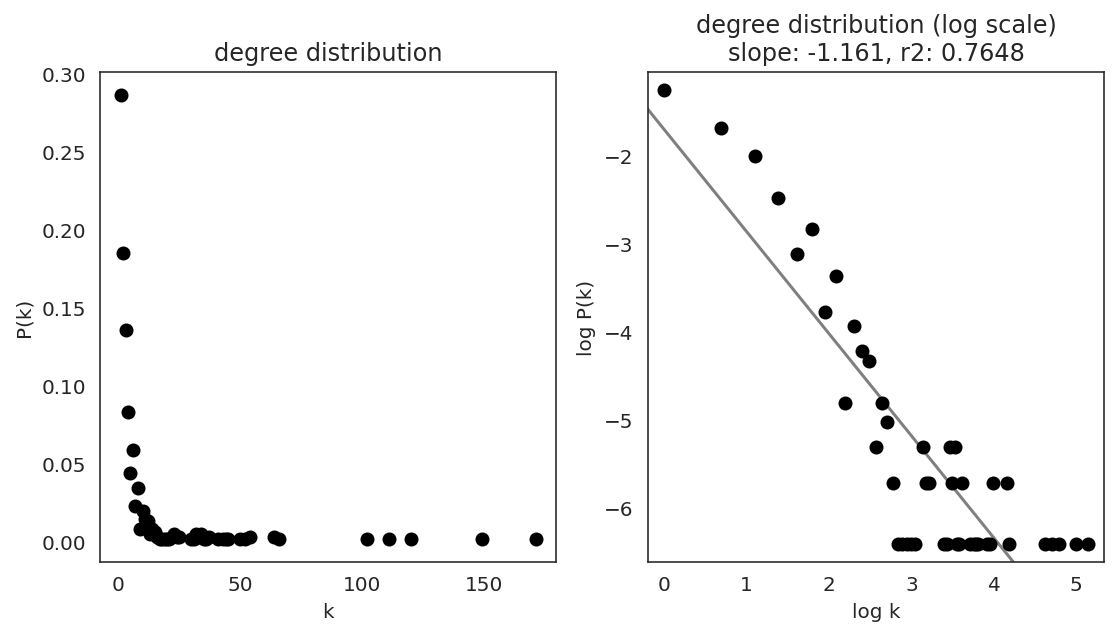

Ery_4


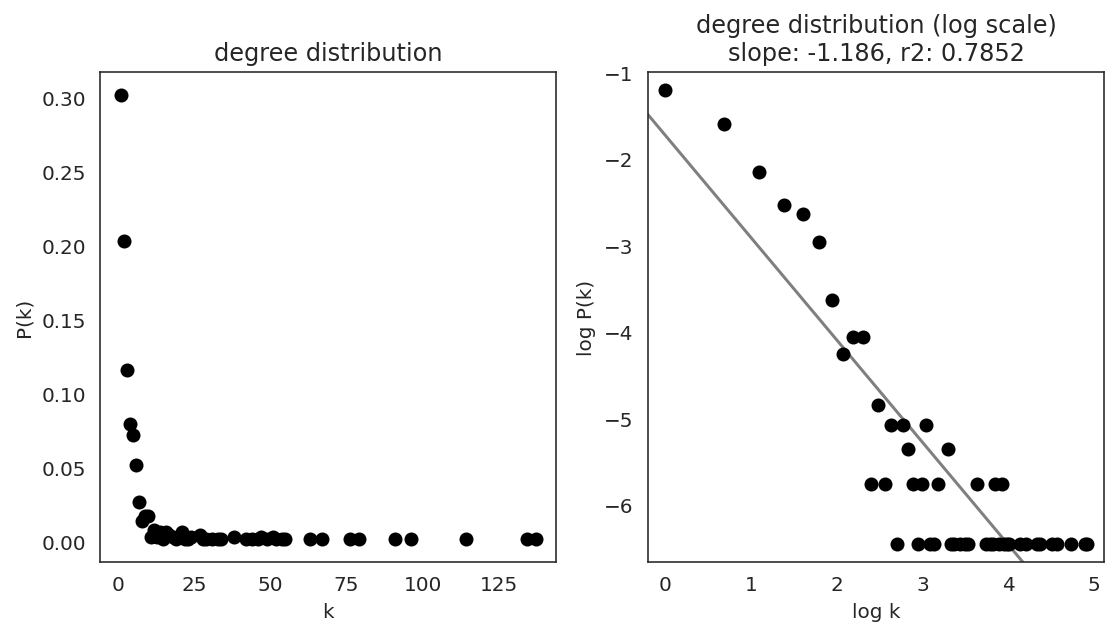

Ery_5


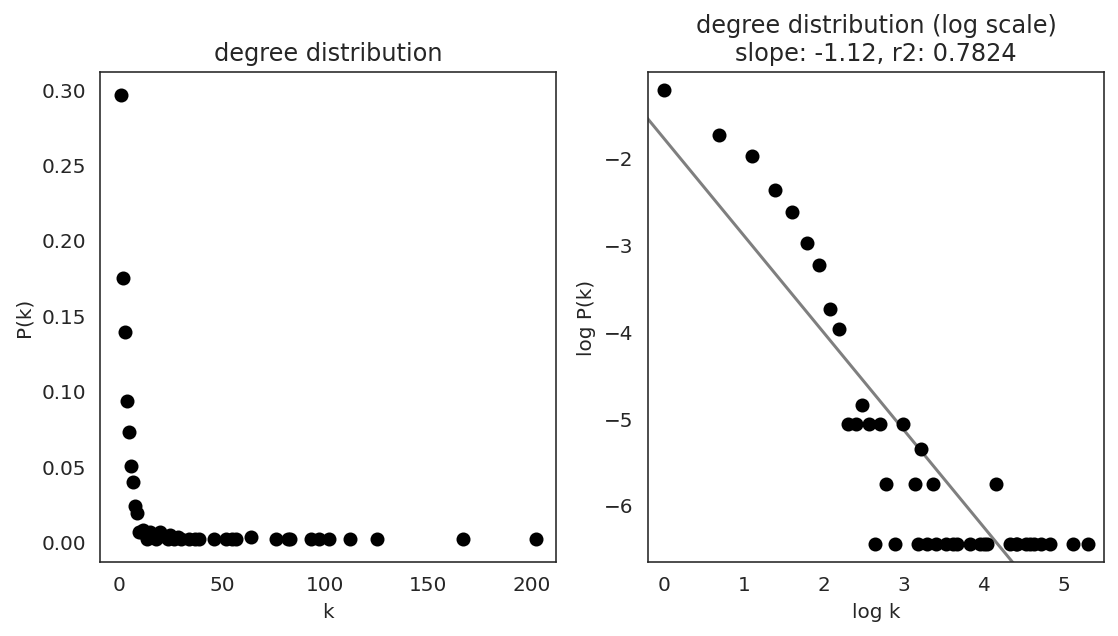

Ery_6


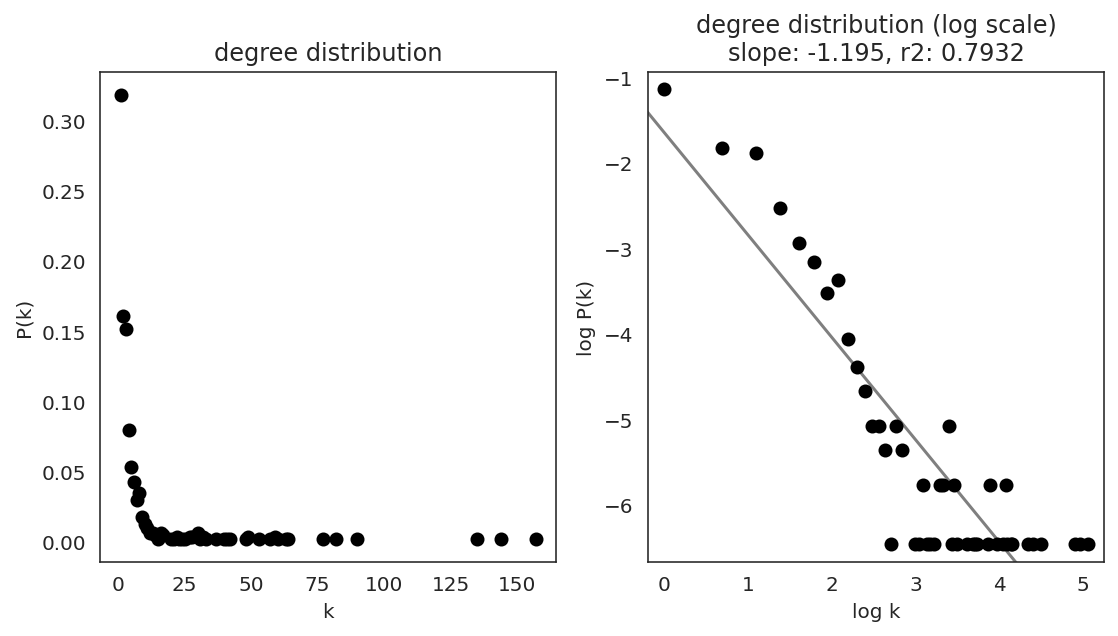

Ery_7


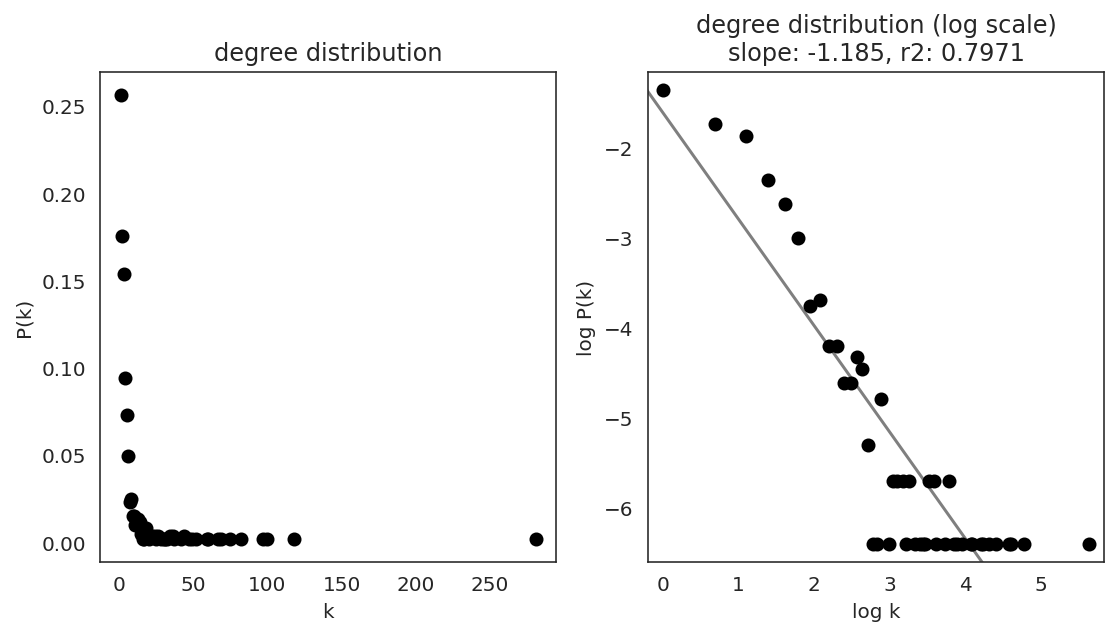

Ery_8


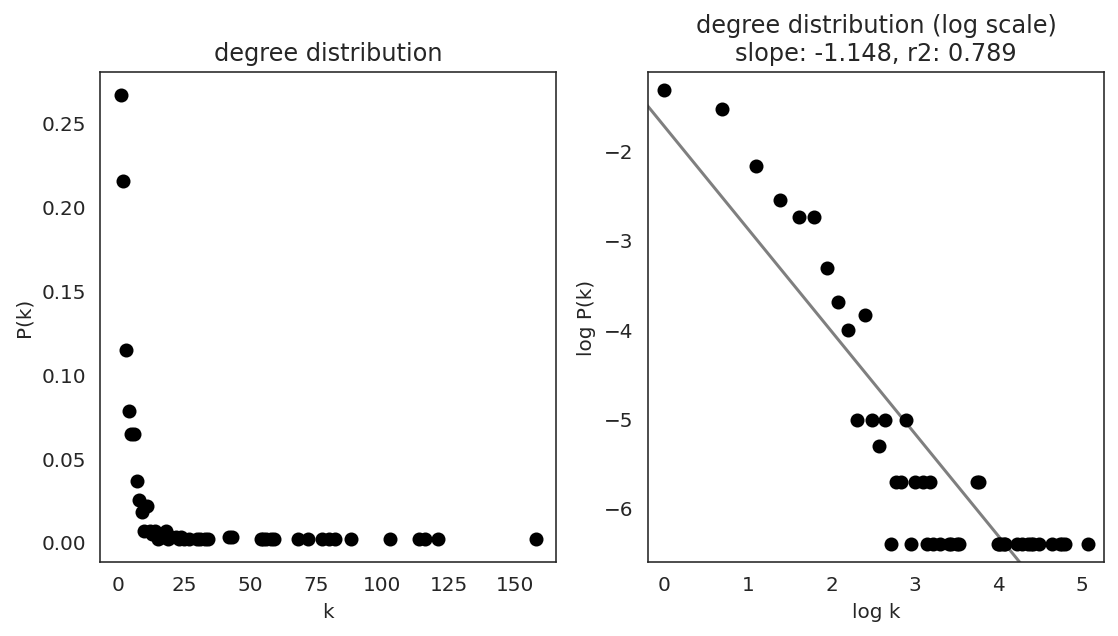

Ery_9


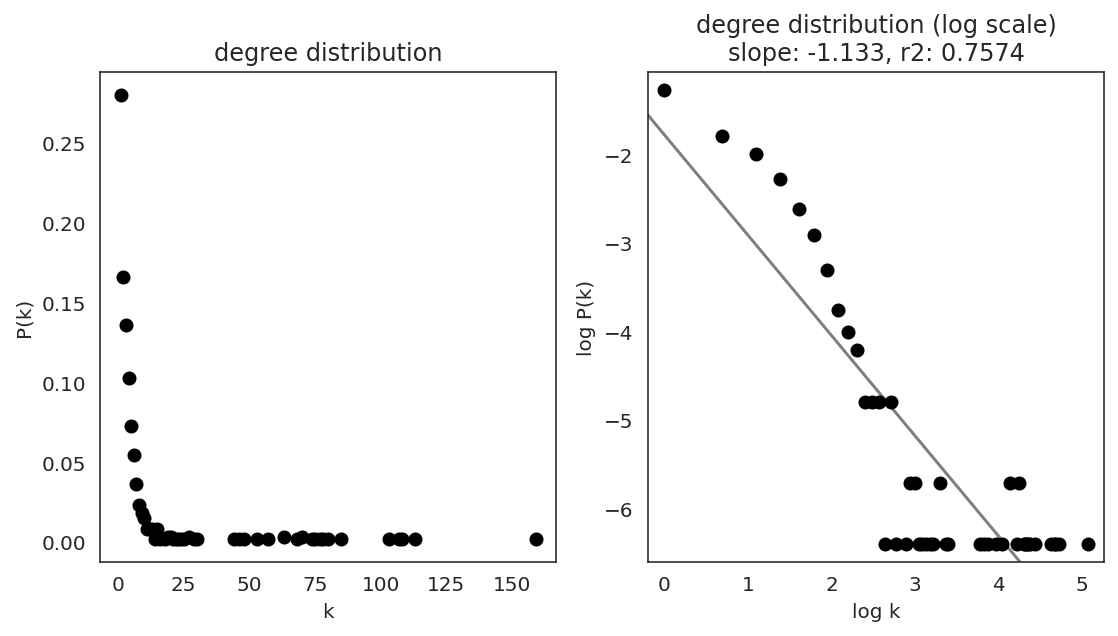

GMP_0


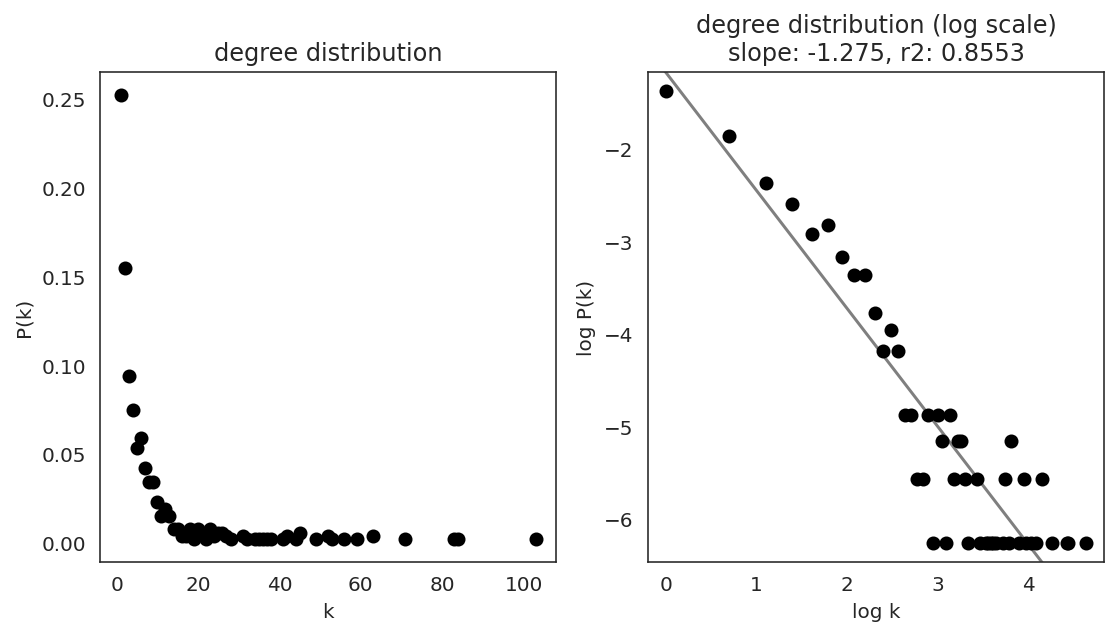

GMP_1


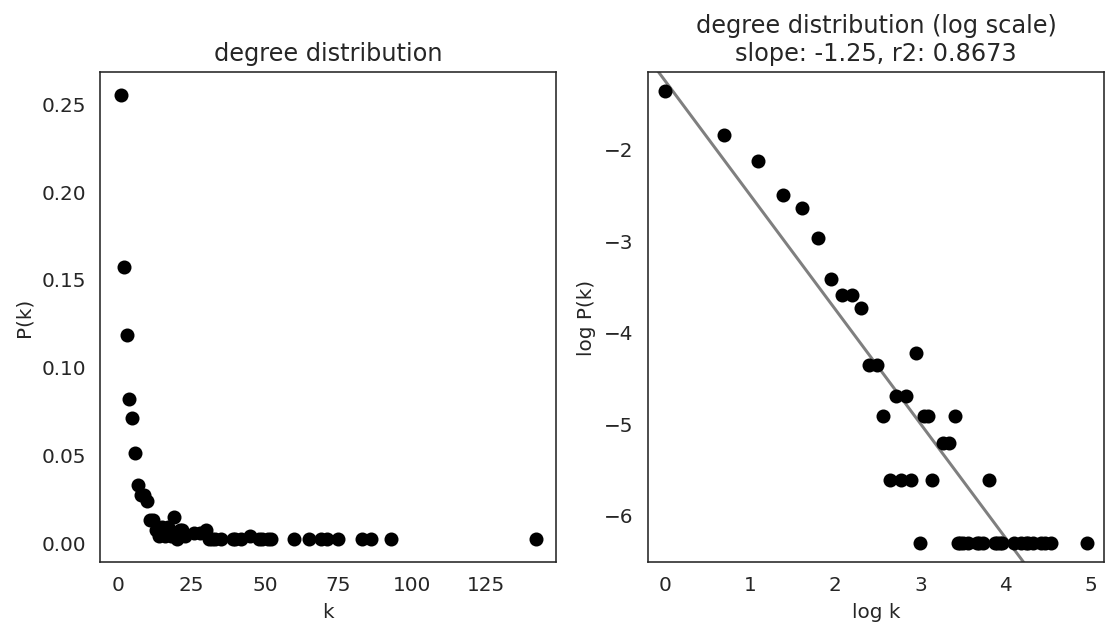

GMP_2


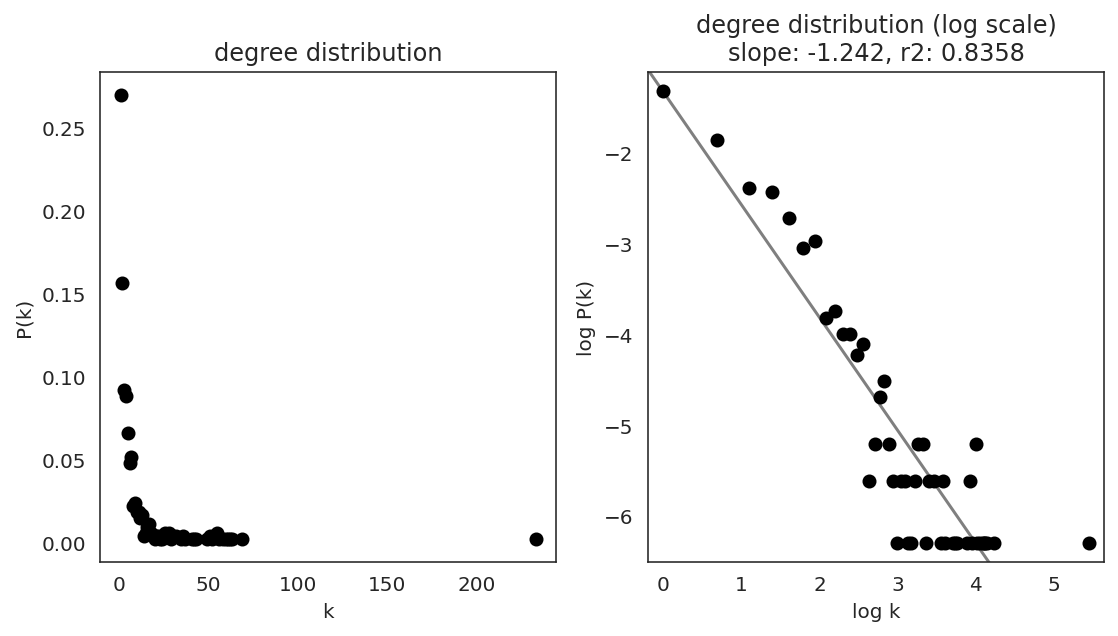

GMPl_0


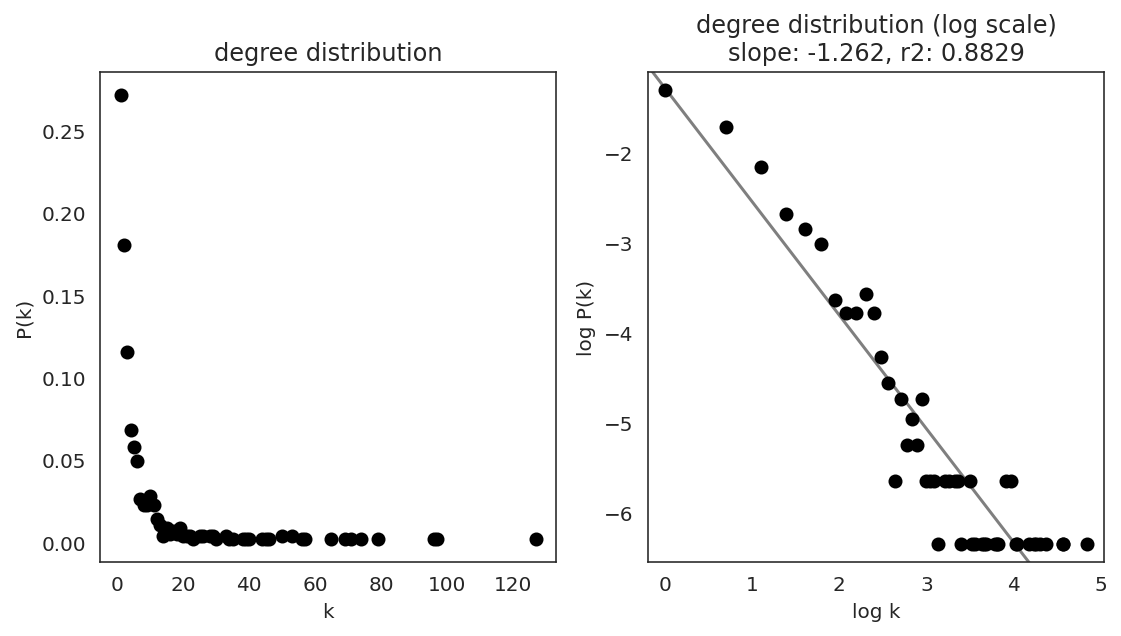

GMPl_1


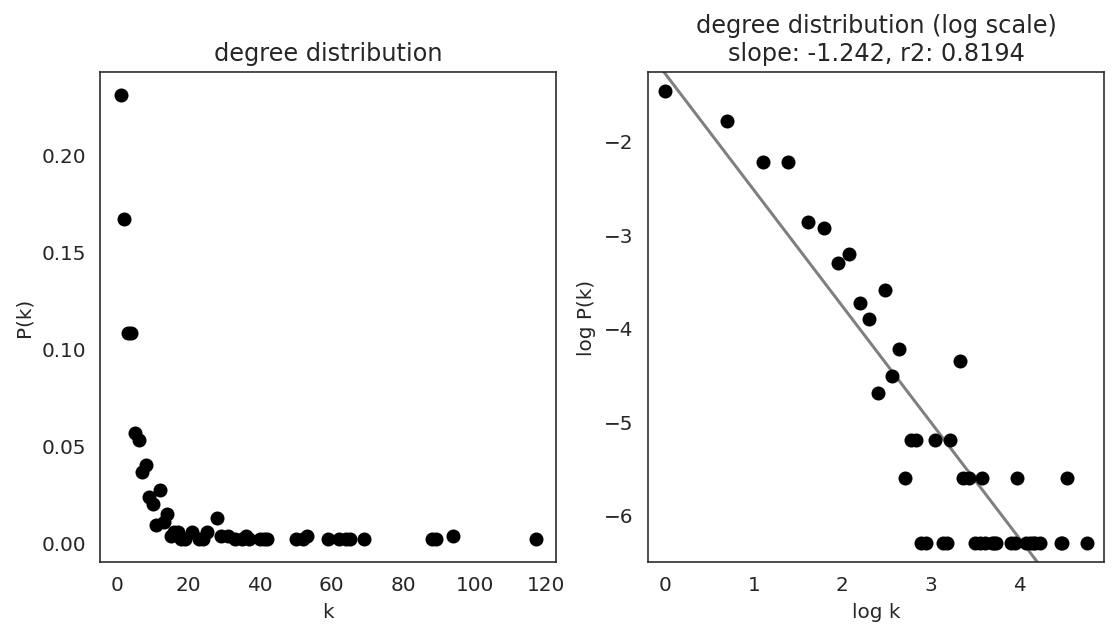

Gran_0


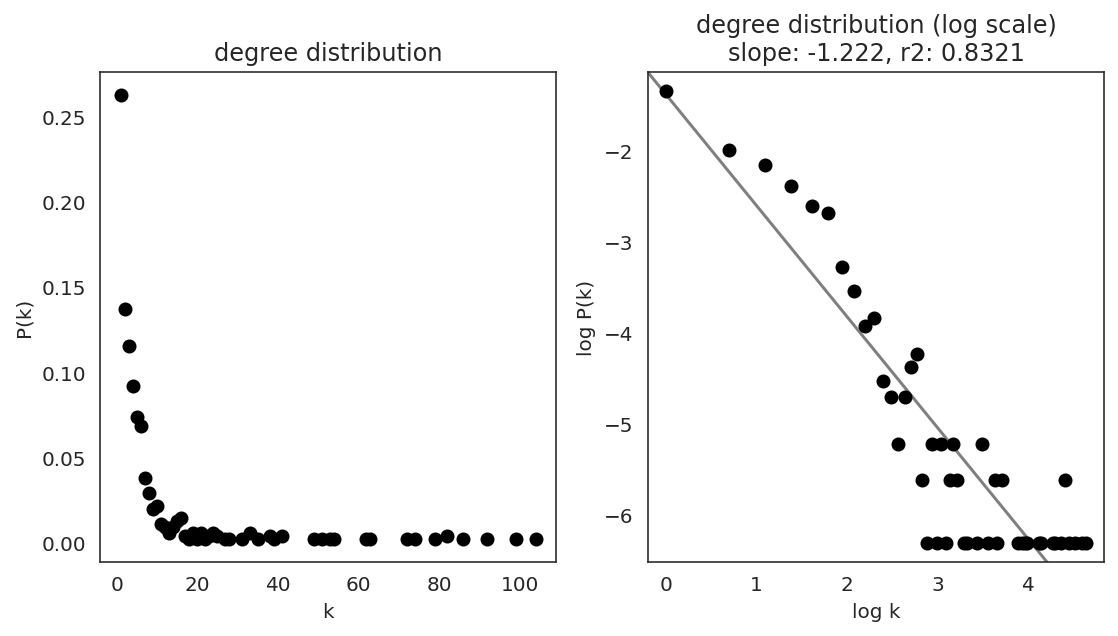

Gran_1


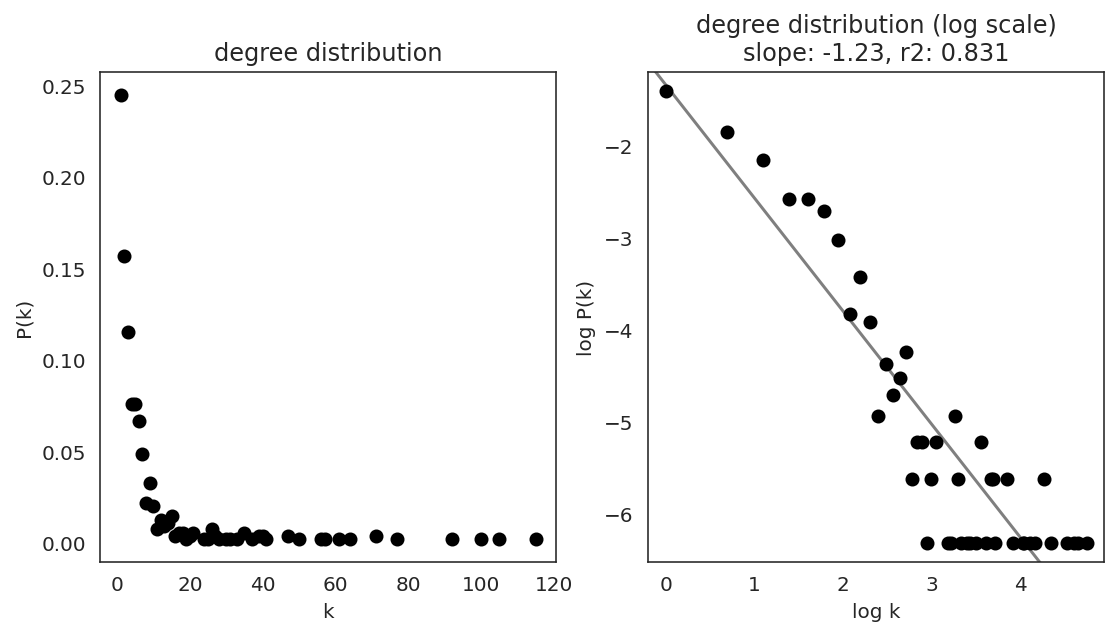

Gran_2


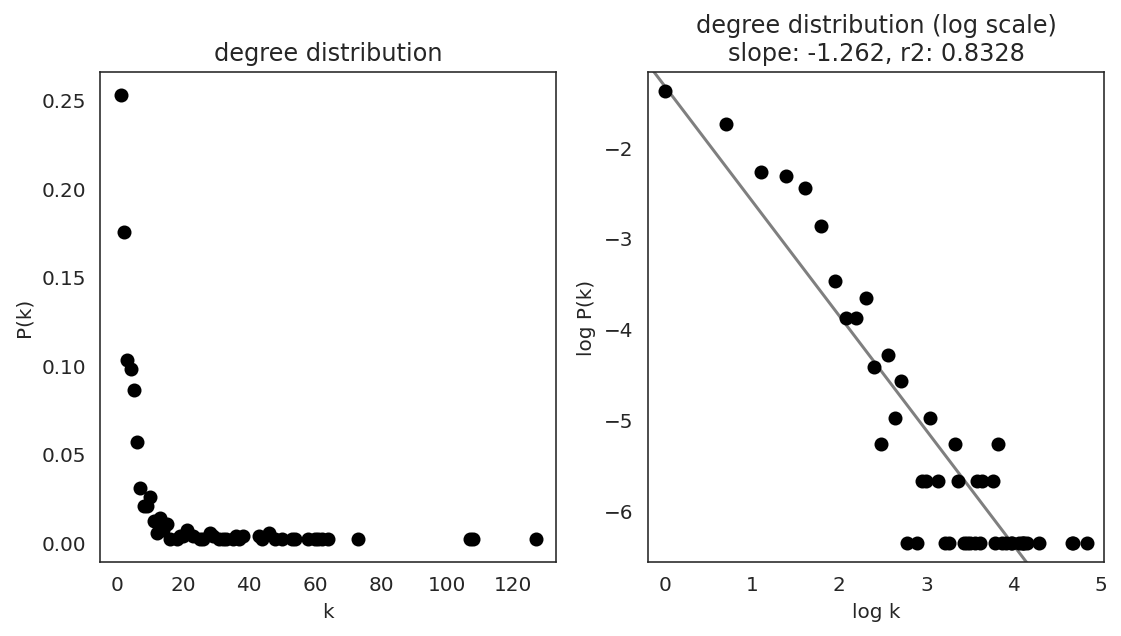

Gran_3


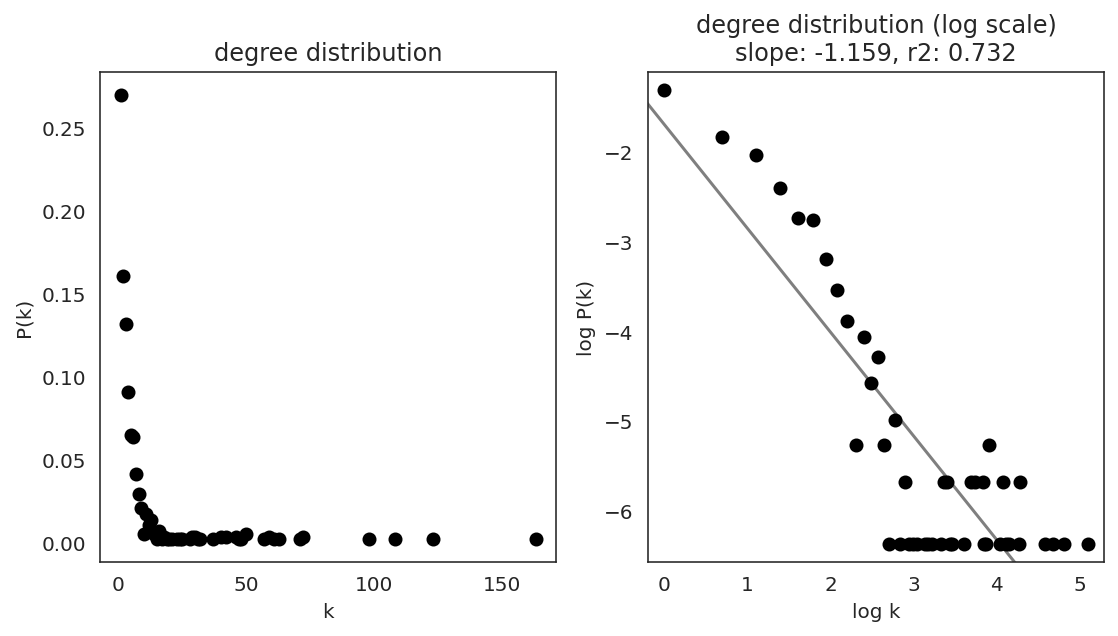

MEP_0


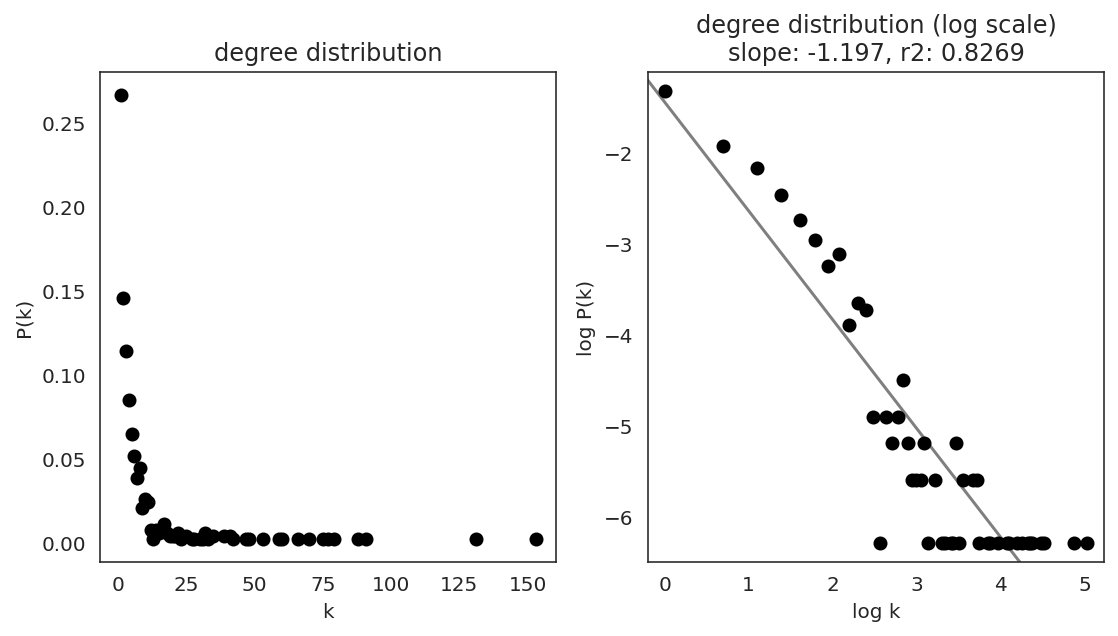

Mk_0


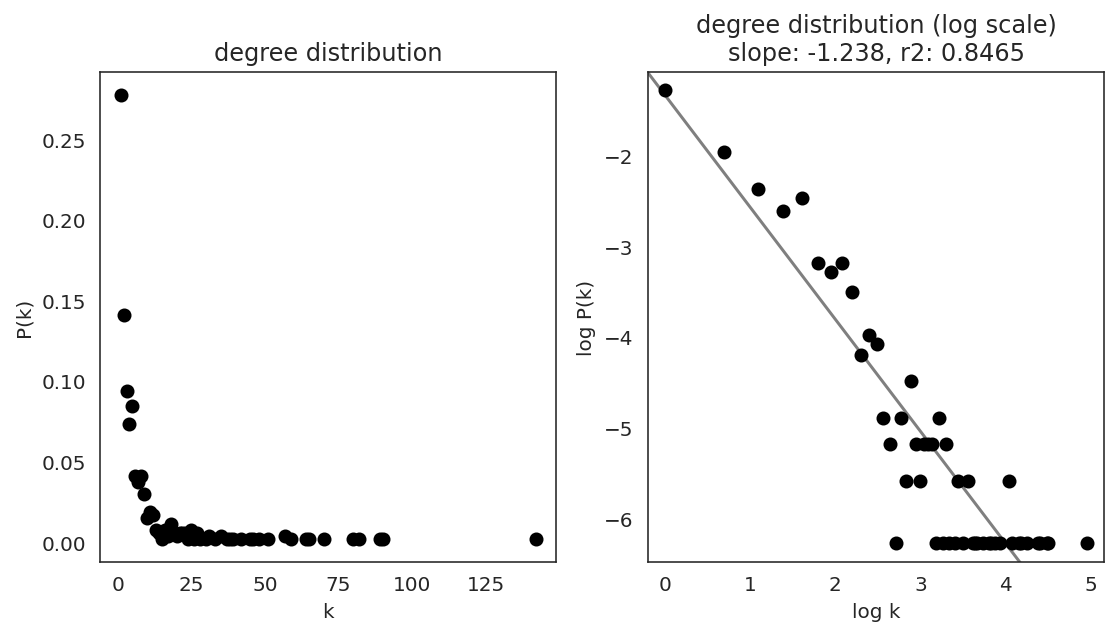

Mo_0


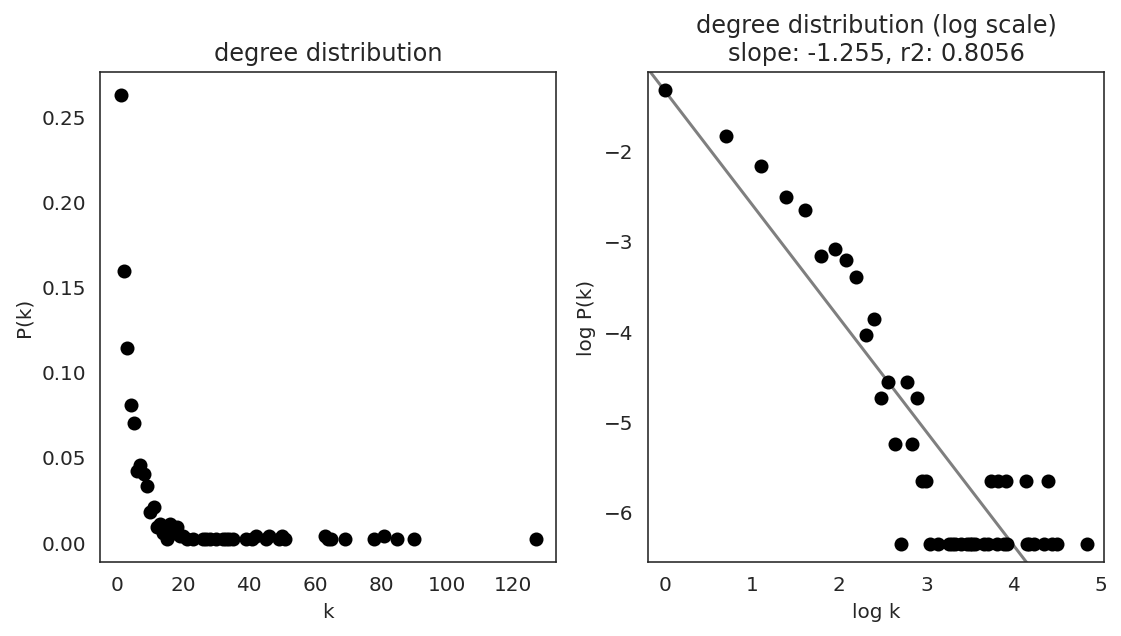

Mo_1


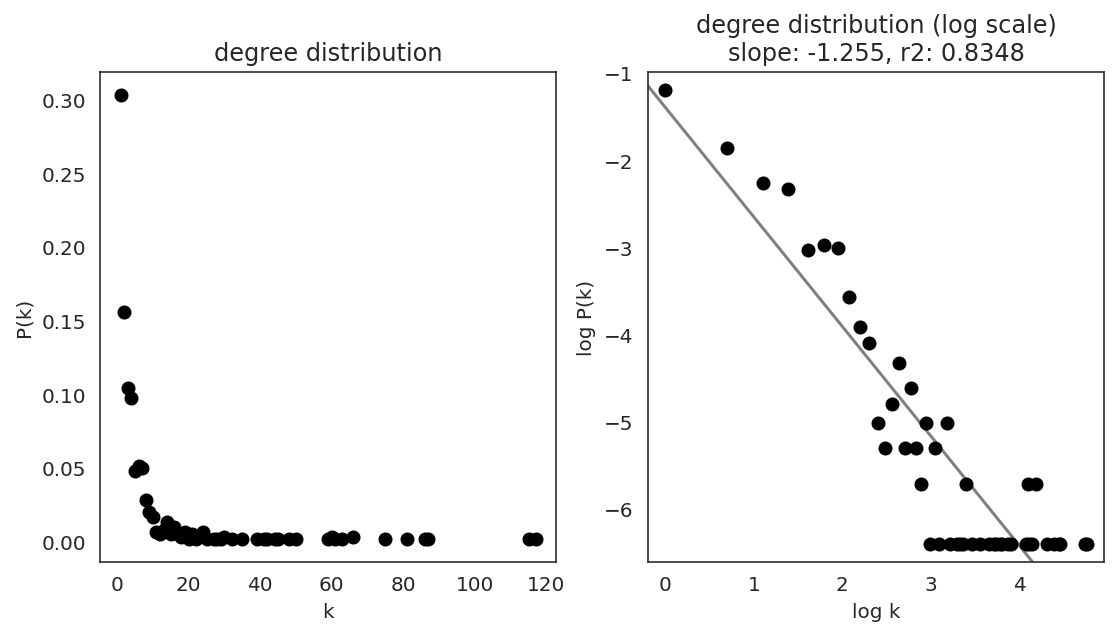

Mo_2


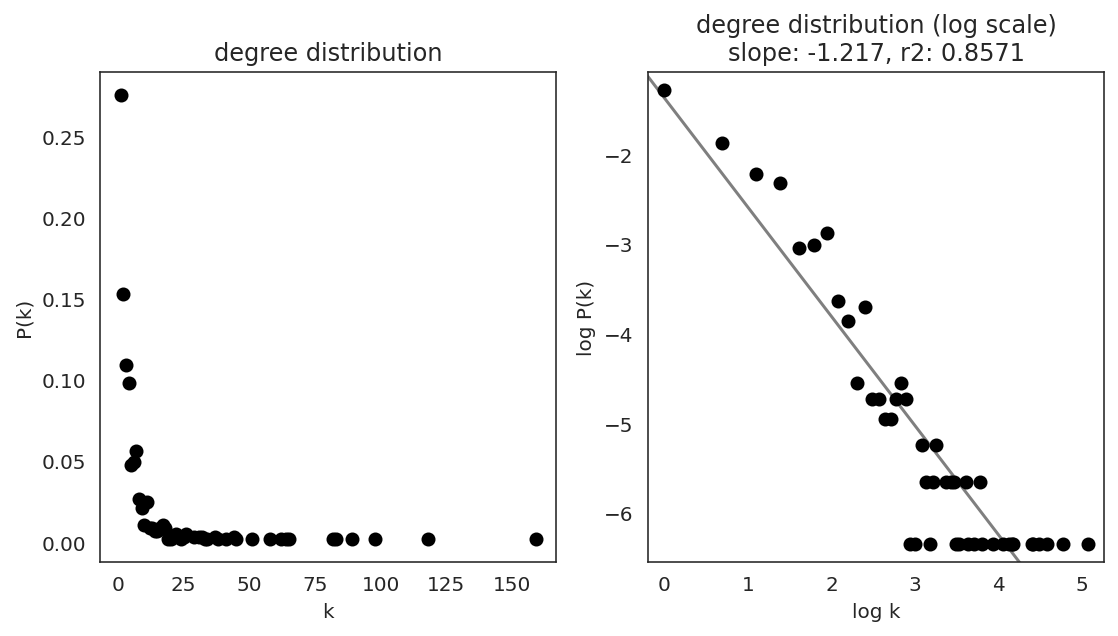

In [33]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [34]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 6.3. Calculate netowrk score

Next, we calculate several network scores.


Although previous version of celloracle, `links.get_score()` required R packages for the netowrk score calculation, the function was replaced with new function, `links.get_network_scores()`, which does NOT require any R package. This new function can be available with celloracle >= 0.10.0.

The old function, `links.get_score()` is still available, but it will be removed in the future version.


In [35]:
# Calculate network scores. 
links.get_network_score()

The score is stored as a attribute `merged_score`.

In [36]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
0610010K14Rik,3,0.005435,3,0.005435,0,0.0,0.0,0.025287,Ery_0
1300001I01Rik,3,0.005435,3,0.005435,0,0.0,0.0,0.065949,Ery_0
1500001M20Rik,1,0.001812,1,0.001812,0,0.0,0.0,0.012939,Ery_0
1500012F01Rik,9,0.016304,9,0.016304,0,0.0,0.0,0.115369,Ery_0
1700017B05Rik,2,0.003623,2,0.003623,0,0.0,0.0,0.007329,Ery_0


## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

In [37]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [38]:
# You can load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")


**If you are not interested in network analysis you can skip the steps described below. 
Please go to the next step: in silico gene perturbation with GRNs**

https://morris-lab.github.io/CellOracle.documentation/tutorials/simulation.html

# 7. Network analysis; Network score for each gene
The `Links` class has many functions to visualize network score.
See the web documentation to learn more about these functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
>Centrality matrics are is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [39]:
# Check cluster name
links.cluster

['Ery_0',
 'Ery_1',
 'Ery_2',
 'Ery_3',
 'Ery_4',
 'Ery_5',
 'Ery_6',
 'Ery_7',
 'Ery_8',
 'Ery_9',
 'GMP_0',
 'GMP_1',
 'GMP_2',
 'GMPl_0',
 'GMPl_1',
 'Gran_0',
 'Gran_1',
 'Gran_2',
 'Gran_3',
 'MEP_0',
 'Mk_0',
 'Mo_0',
 'Mo_1',
 'Mo_2']

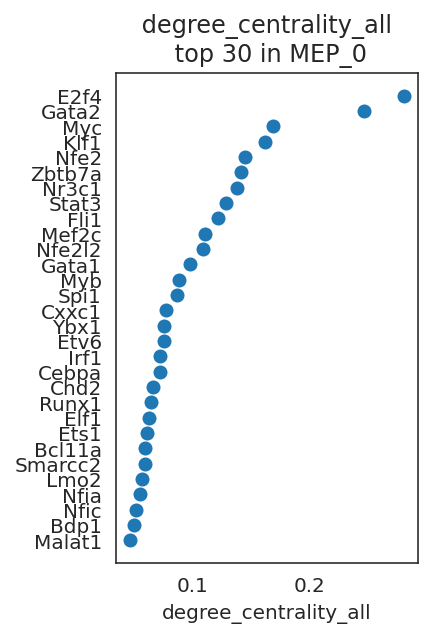

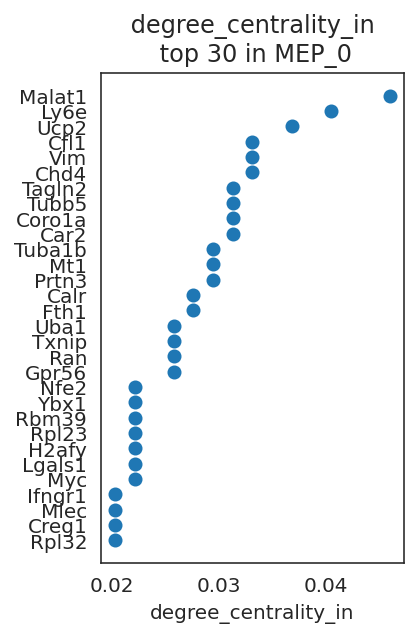

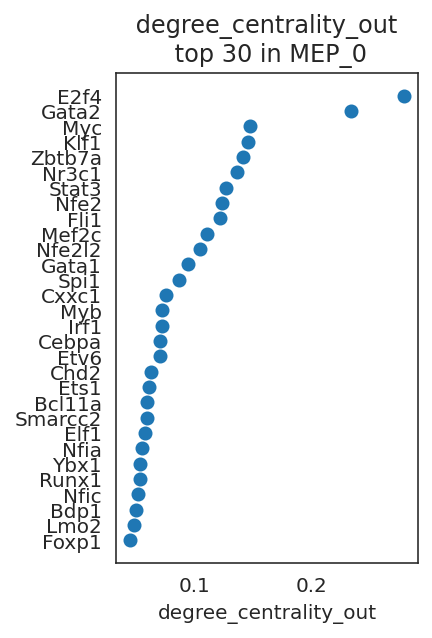

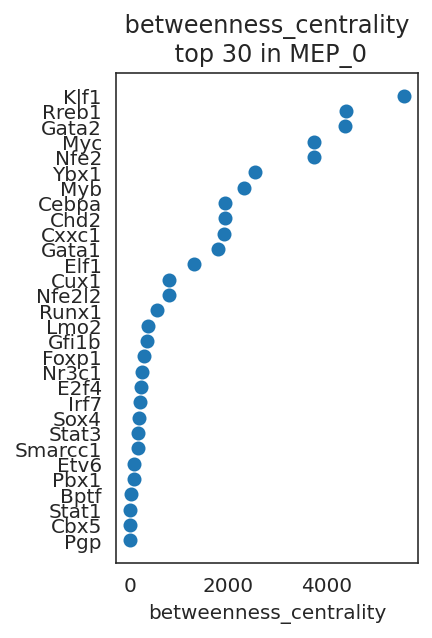

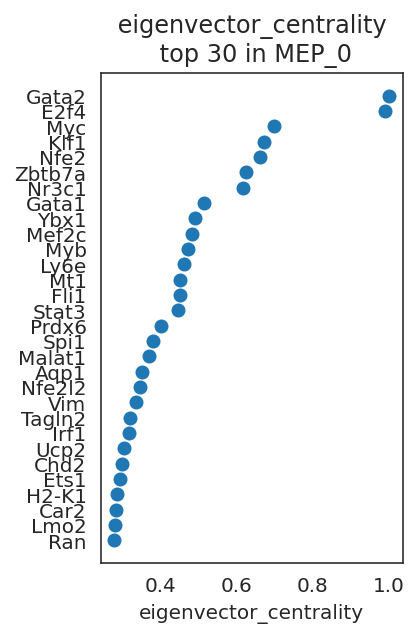

In [40]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="MEP_0", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

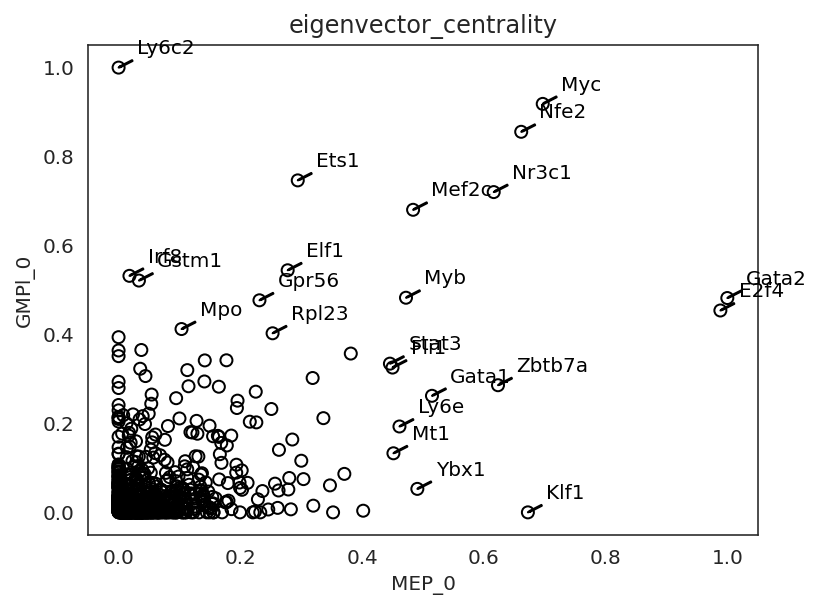

In [41]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

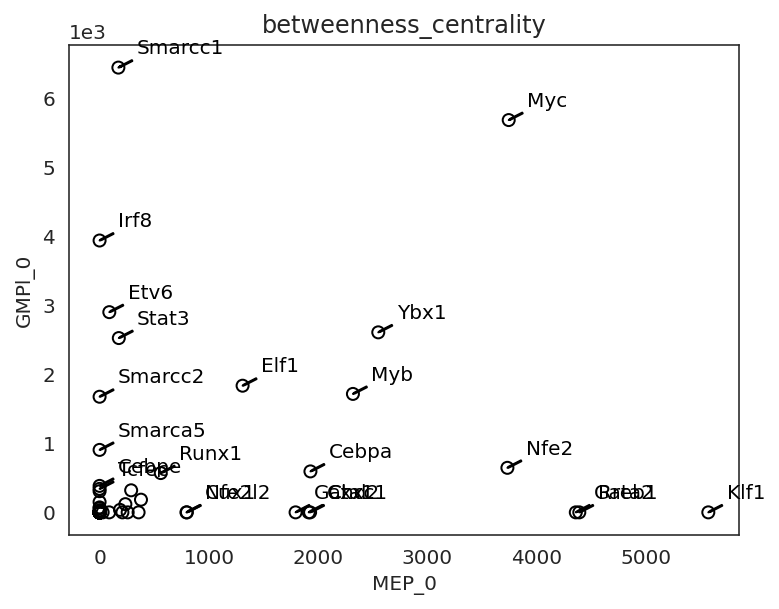

In [42]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

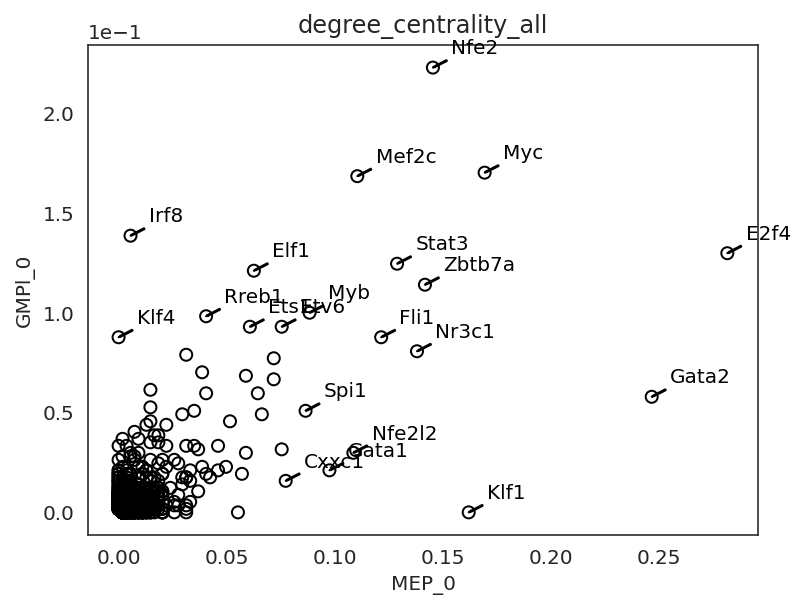

In [43]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

## 7.3. Network score dynamics
In the following section, we focus on how a gene's network score changes during the differentiation.

We will introduce how to visualize networks scores dynamics using Gata2 as an example.

Gata2 is known to play an essential role in the early MEP and GMP populations. .

Gata2


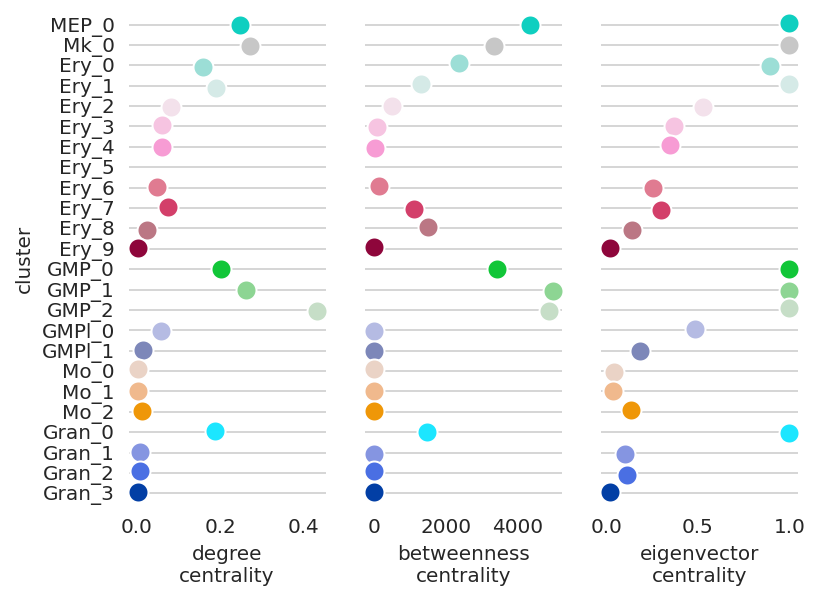

In [44]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="Gata2", save=f"{save_folder}/network_score_per_gene/")

If a gene does not have network edge in a cluster, the network scores cannot be calculated and the scores will not be shown.
For example, Cebpa have no network edge in the erythloids cluster GRNs. Thus these clusters do not have centrality scores in the plot below.

Cebpa


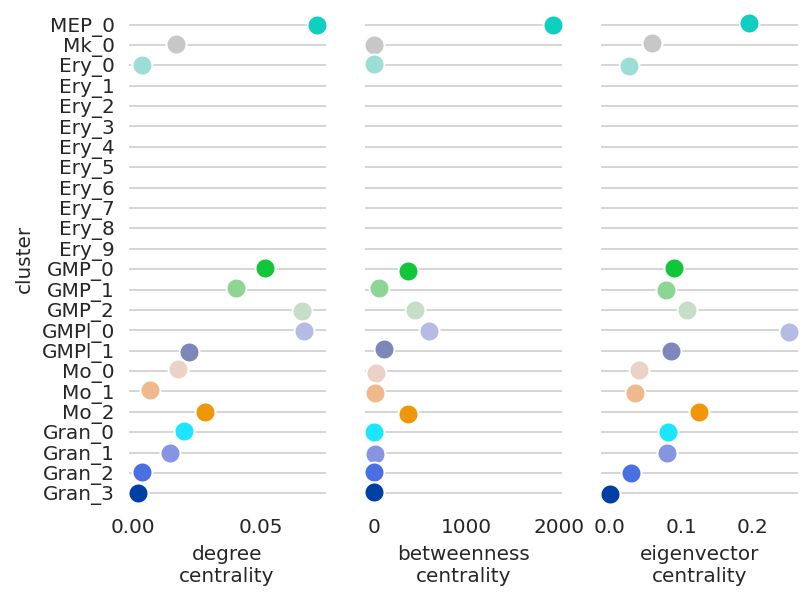

In [45]:
links.plot_score_per_cluster(goi="Cebpa")

You can check the filtered network edge as follows.

In [46]:
cluster_name = "Ery_1"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
5513,Gata2,Apoe,0.104739,0.104739,2.733532e-15,14.563276
5510,Zfhx3,Apoe,0.096349,0.096349,4.500256e-14,13.346763
69223,Elf1,Top2a,0.093669,0.093669,5.660438e-13,12.247150
56733,Gata2,Rhd,-0.093533,0.093533,1.233370e-11,10.908907
5540,Nfatc3,Apoe,-0.088600,0.088600,1.138016e-15,14.943852


You can confirm that there is no Cebpa connection in Ery_0 cluster.

In [47]:
filtered_links_df[filtered_links_df.source == "Cebpa"]

,source,target,coef_mean,coef_abs,p,-logp


# 8. Network analysis; network score distribution

Next, we visualize the network score distributions to get insight into the global network trends.

## 8.1. Distribution of network degree

In [48]:
plt.rcParams["figure.figsize"] = [6, 4.5]

degree_centrality_all


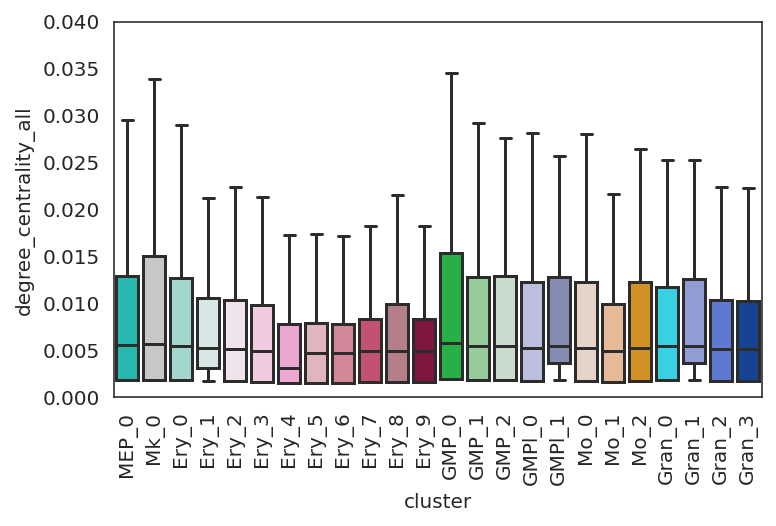

In [49]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot", 
                               #save=f"{save_folder}",
                              )



eigenvector_centrality


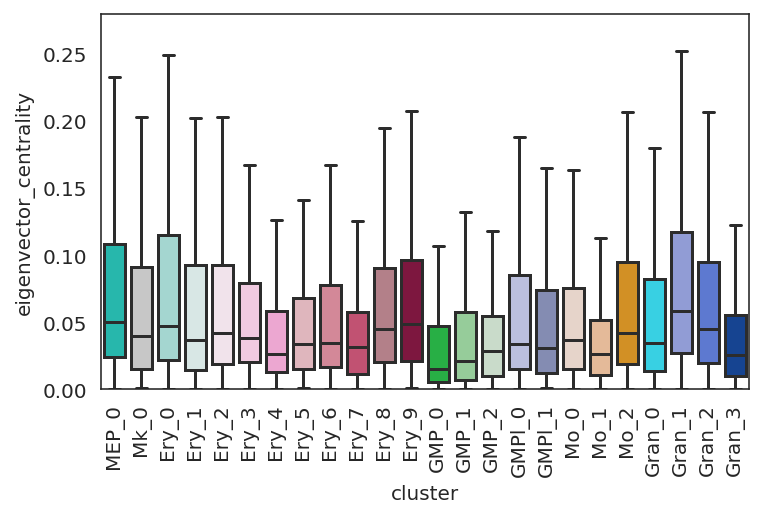

In [50]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.28])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot", save=f"{save_folder}")




## 8.2. Distribution of netowrk entropy

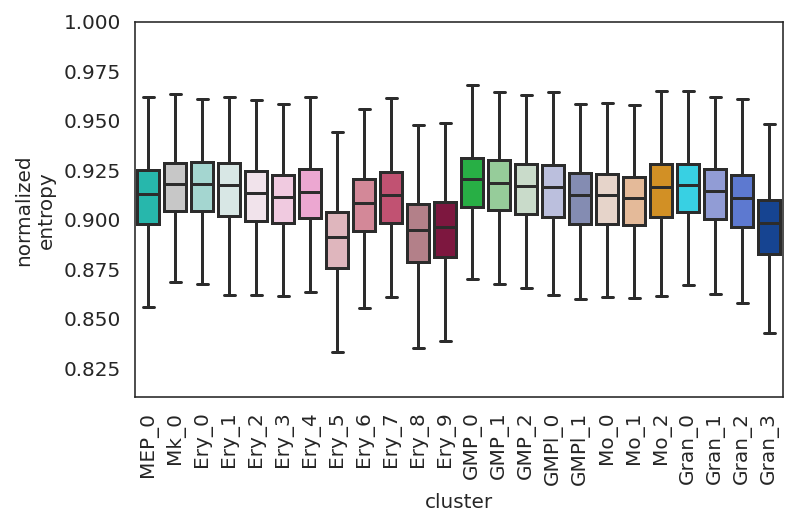

In [51]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")



Please go to the next step: **in silico gene perturbation with GRNs**

https://morris-lab.github.io/CellOracle.documentation/tutorials/simulation.html